In [1]:
# Install all dependencies
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tabulate
!{sys.executable} -m pip install matplotlib2tikz

In [4]:
# config
#DIRS = ['/Users/tzwickl/Documents/TumStudy/MasterStudy/MasterThesis/TUM/InterruptsInUserSpaceDrivers/Experiments/Experiment1/Uniform/ITR']
DIRS = ['/Users/tzwickl/Documents/TumStudy/MasterStudy/MasterThesis/TUM/InterruptsInUserSpaceDrivers/Experiments/Experiment2/Poisson/ITR']
RUNTIME = 1
CPU_FREQUENCY = 2.4 * (10**9)

In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import matplotlib2tikz
import matplotlib.ticker as tick
import csv
import re

In [47]:
fresults = {}

for d in DIRS:
    itrs = os.listdir(d)
    itrs = list(map(lambda itr: str(itr), sorted(map(lambda itr: int(itr) if itr.isnumeric() else -1, itrs))))
    for itr in itrs:
        path = os.path.join(d, itr)
        if not os.path.isdir(path):
            continue
        files = os.listdir(path)
        
        fresults[itr] = {}
        
        flatency = fresults[itr]["latency"] = []
        flatency_ = filter(lambda x: x.startswith('histo'), files)
        flatency.extend(map(lambda x: os.path.join(path, x), flatency_))

        fresult = fresults[itr]["result"] = []
        fresult_ = filter(lambda x: x.startswith('result'), files)
        fresult.extend(map(lambda x: os.path.join(path, x), fresult_))



In [7]:
# export figure to pgf
def export_to_pgf(plt, label):
    matplotlib2tikz.save(label + ".tex", figureheight = '\\figH', figurewidth = '\\figW')

In [48]:
results = {}

for itr in fresults:
    results[itr] = {}
    with open(fresults[itr]["result"][0]) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            results[itr][row[0]] = {}
            results[itr][row[0]]["irq"] = int(row[1])
            results[itr][row[0]]["irq/s"] = int(row[1]) / RUNTIME
            results[itr][row[0]]["tx"] = int(row[2])
            results[itr][row[0]]["rx"] = int(row[3])
            results[itr][row[0]]["lost"] = int(row[2]) - int(row[3])
            results[itr][row[0]]["cpu_cycles"] = int(row[4])
            results[itr][row[0]]["cpu_util"] = int(row[4]) / RUNTIME / CPU_FREQUENCY * 100
            
    for flatency in fresults[itr]["latency"]:
        name = os.path.splitext(os.path.basename(flatency))[0]
        latency = results[itr][name.split('-')[1]]["latency"] = {}
        with open(flatency) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            latency["latency"] = []
            latency["weight"] = []
            for row in csv_reader:
                latency["latency"].append(int(row[0]))
                latency["weight"].append(int(row[1]))

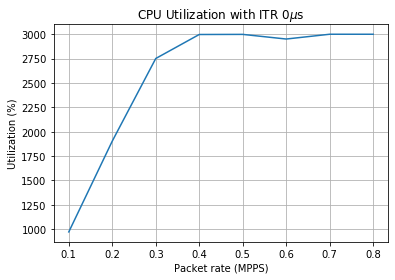

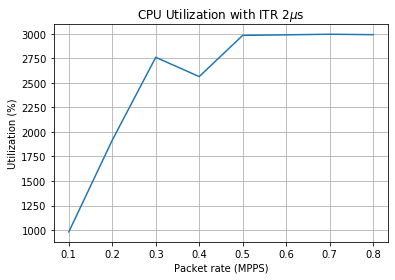

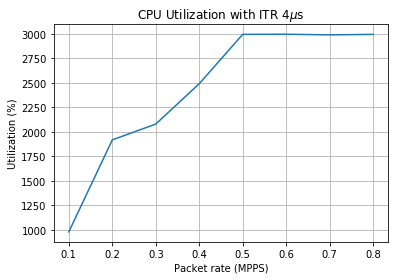

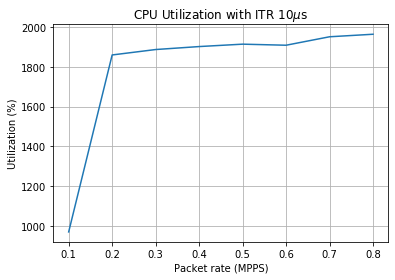

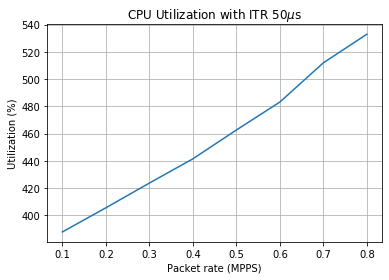

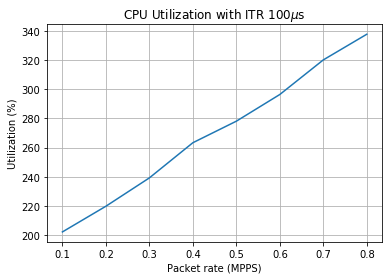

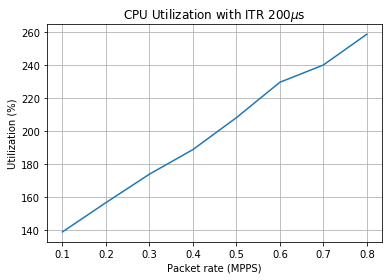

In [49]:
# Plot CPU Util
def plot_cpu_util(cpu_utils, rates, itr):
    fig, ax = plt.subplots()
    ax.plot(rates, cpu_utils)

    ax.set(xlabel='Packet rate (MPPS)', ylabel='Utilization (%)',
           title='CPU Utilization with ITR ' + str(itr) + r'$\mu$s')
    ax.grid()
    plt.show()
    
for itr in results:
    rates = []
    cpu_utils = []
    for rate in results[itr]:
        rates.append(rate)
        cpu_utils.append(results[itr][rate]["cpu_util"])
    plot_cpu_util(cpu_utils, rates, itr)

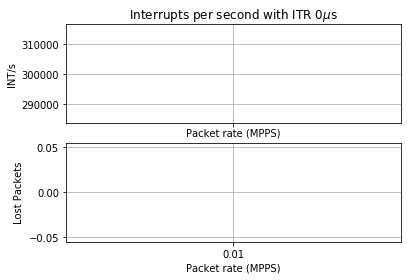

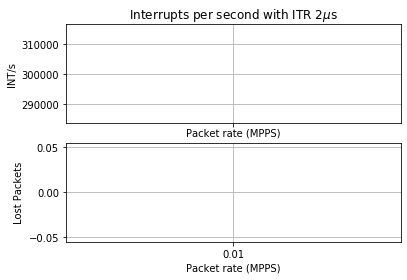

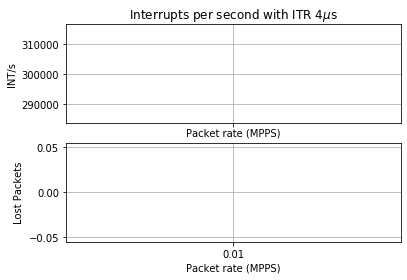

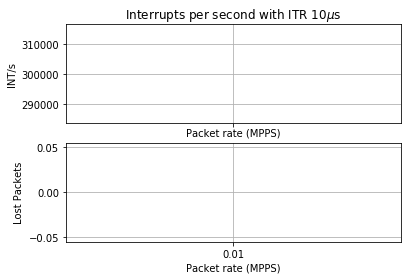

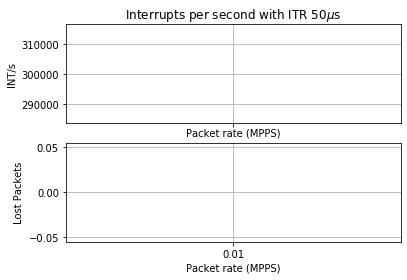

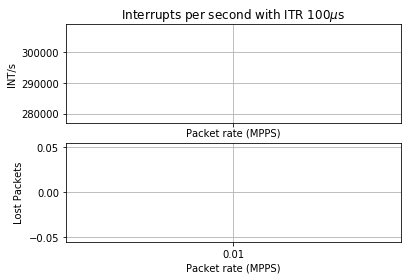

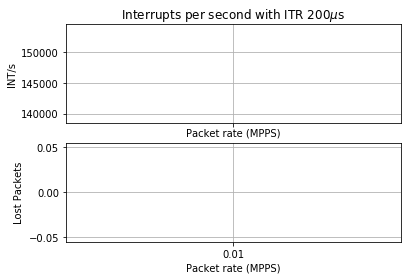

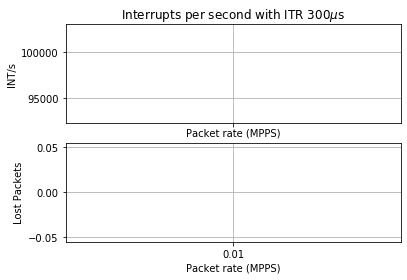

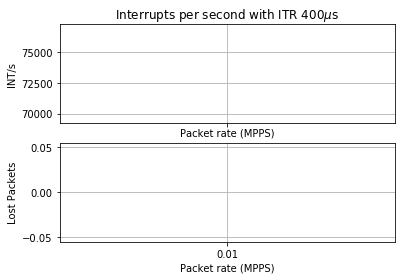

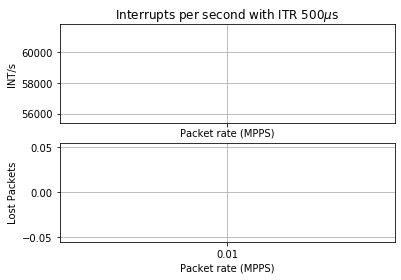

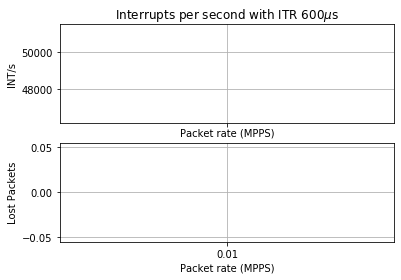

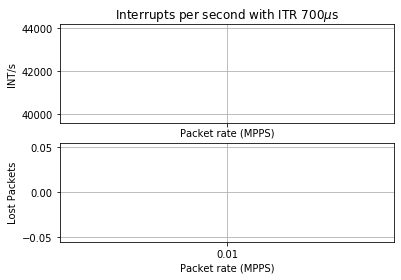

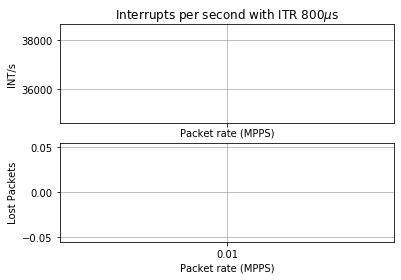

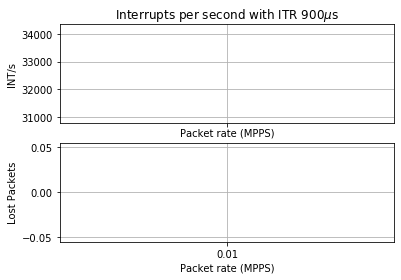

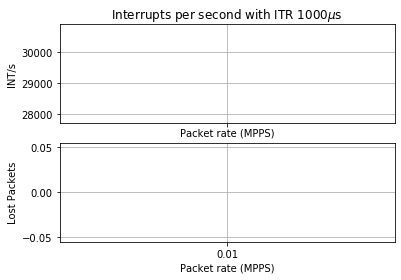

In [28]:
# Plot INT/s
def plot_interrupts_per_second(interrupts, lost, rates, itr):
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.plot(rates, interrupts)
    ax2.plot(rates, lost)

    ax1.set(xlabel='Packet rate (MPPS)', ylabel='INT/s',
           title='Interrupts per second with ITR ' + str(itr) + r'$\mu$s')
    ax1.grid()
    ax2.set(xlabel='Packet rate (MPPS)', ylabel='Lost Packets')
    ax2.grid()
    plt.show()
    
for itr in results:
    rates = []
    lost = []
    interrupts = []
    for rate in results[itr]:
        rates.append(rate)
        interrupts.append(results[itr][rate]["irq/s"])
        lost.append(results[itr][rate]["lost"])
    plot_interrupts_per_second(interrupts, lost, rates, itr)

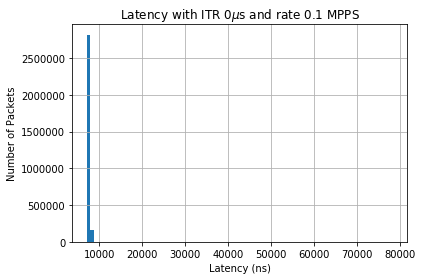

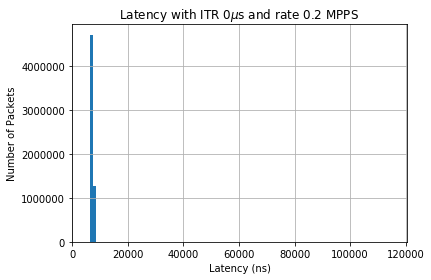

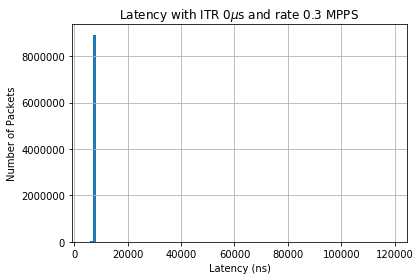

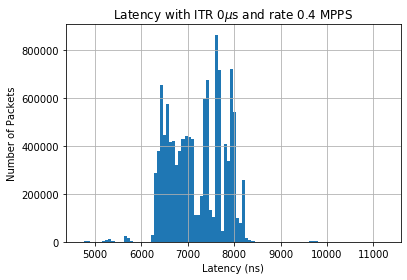

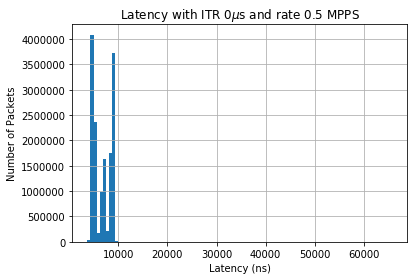

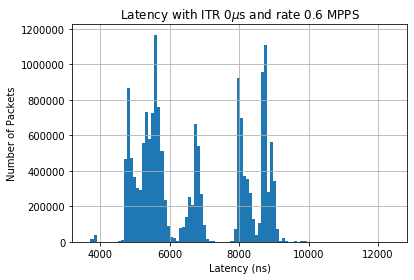

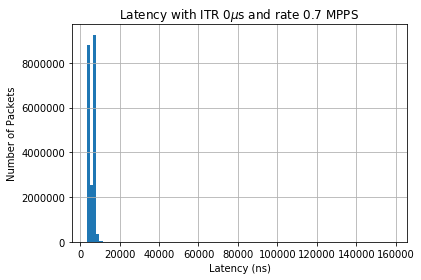

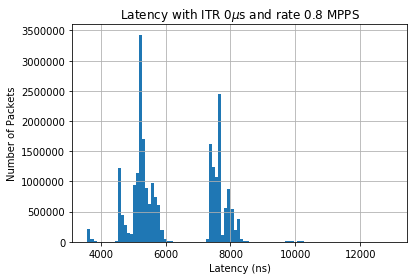

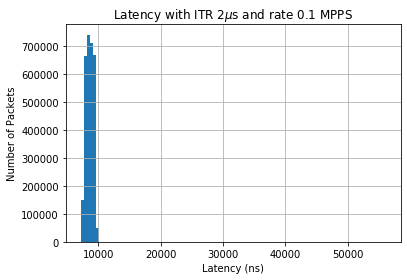

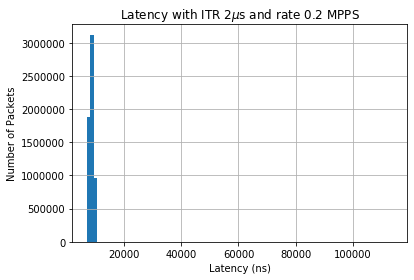

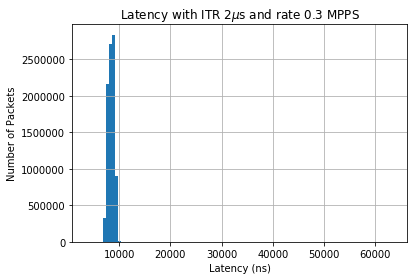

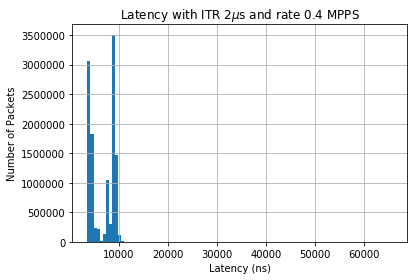

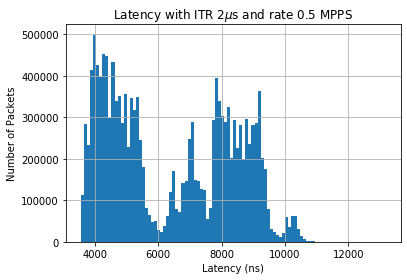

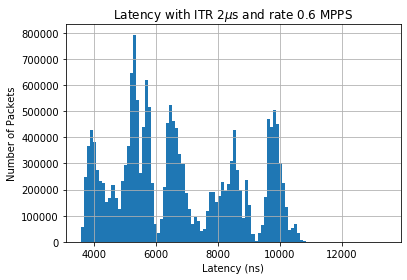

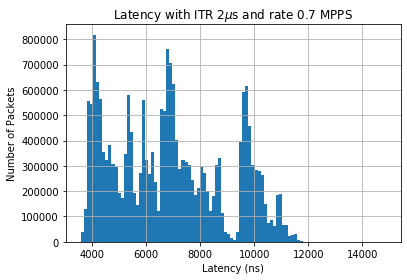

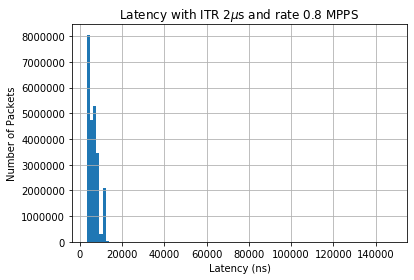

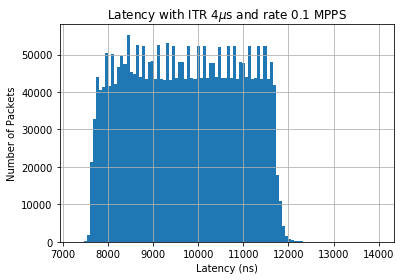

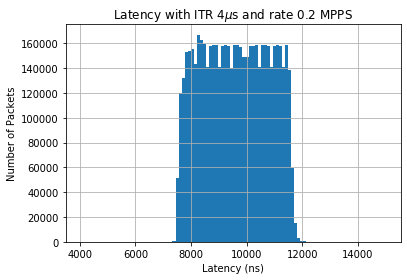

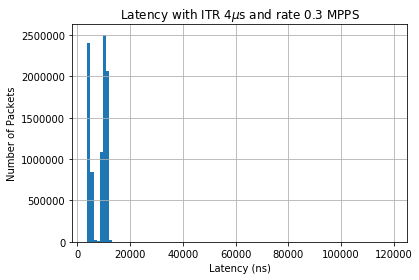

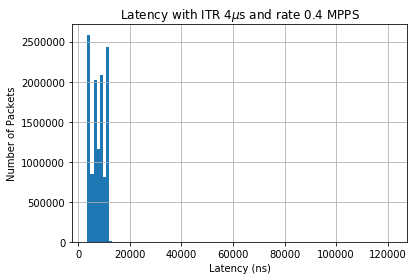

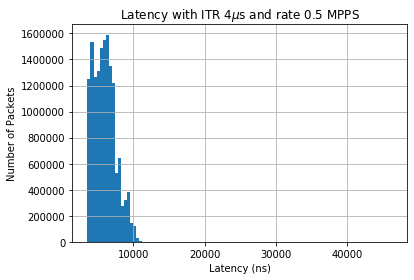

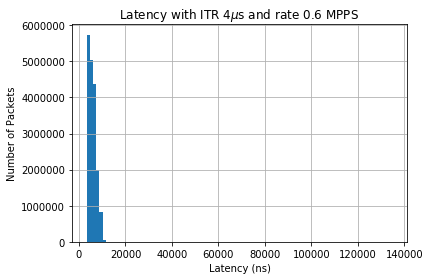

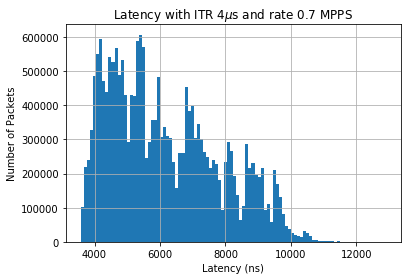

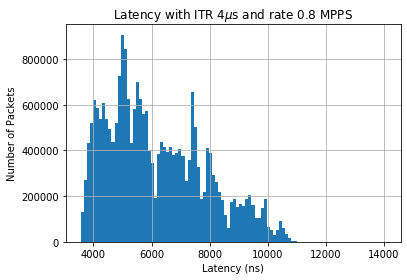

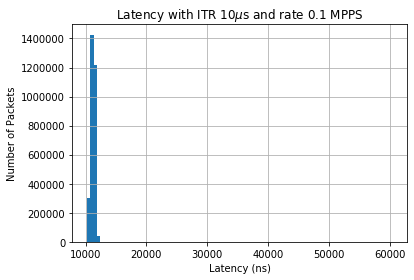

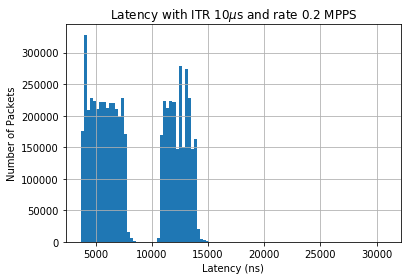

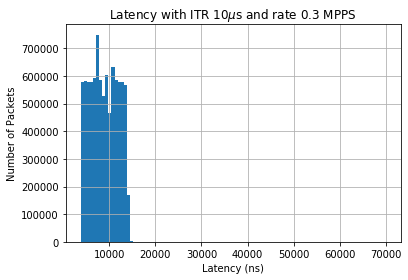

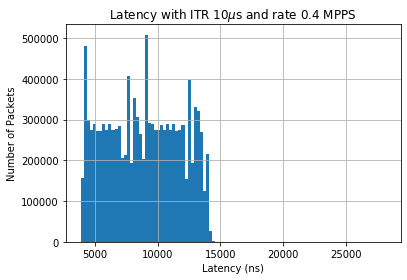

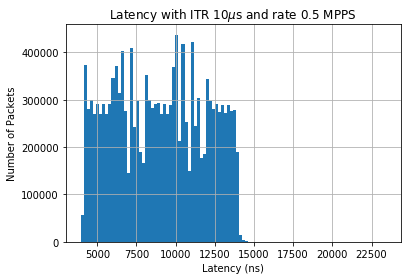

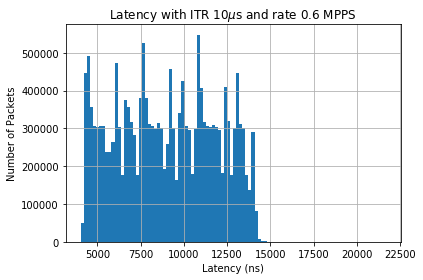

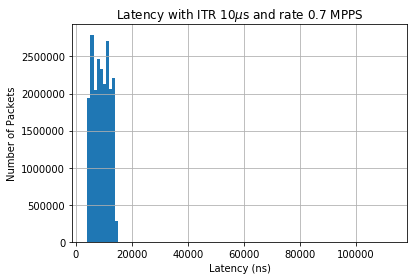

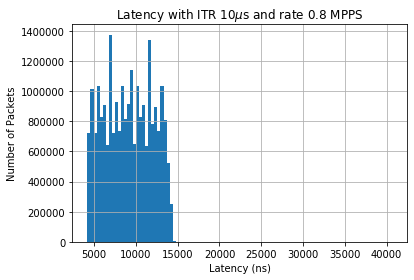

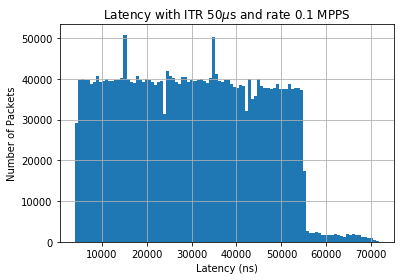

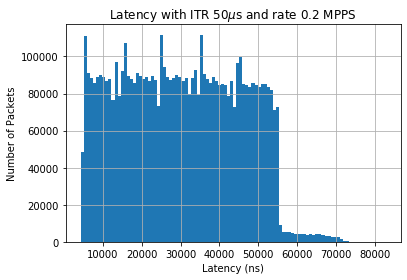

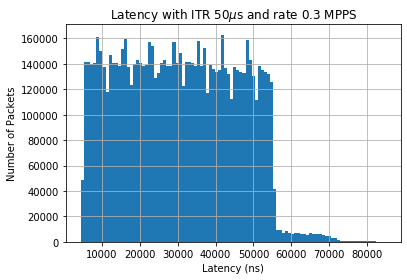

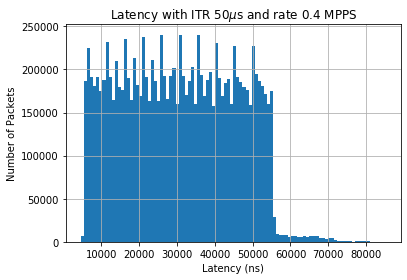

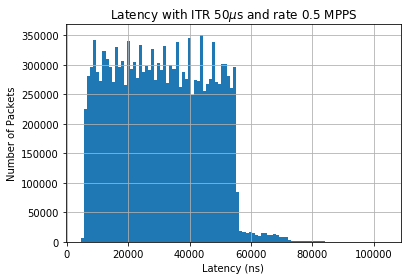

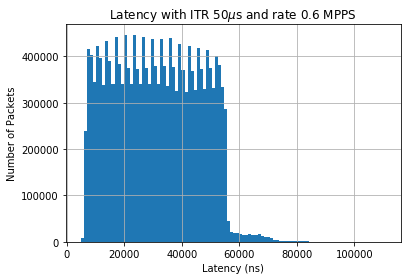

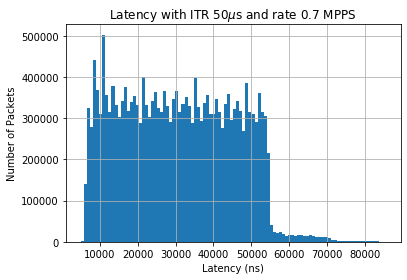

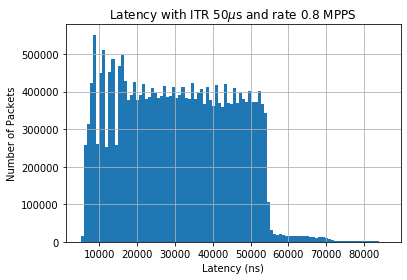

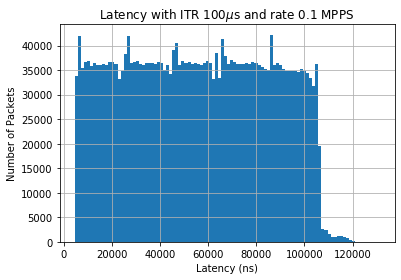

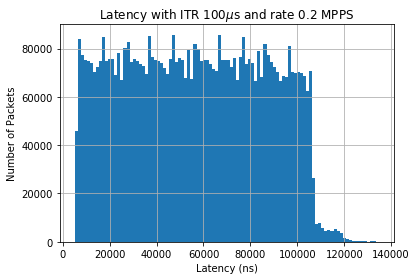

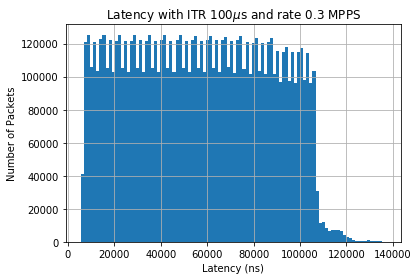

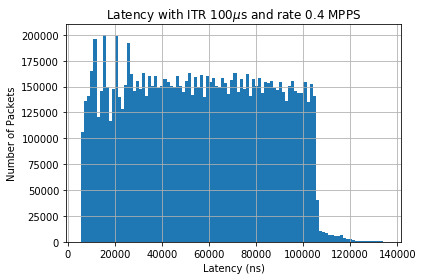

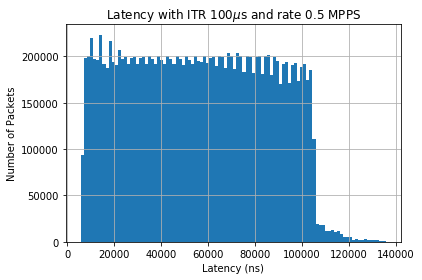

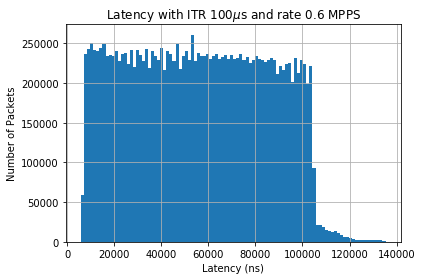

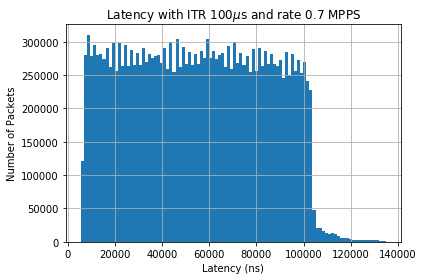

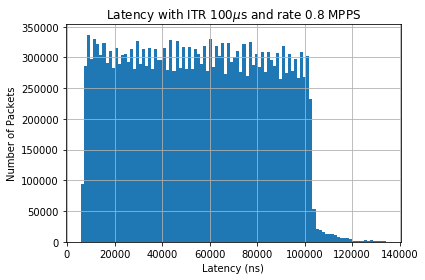

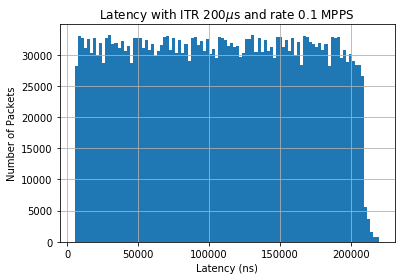

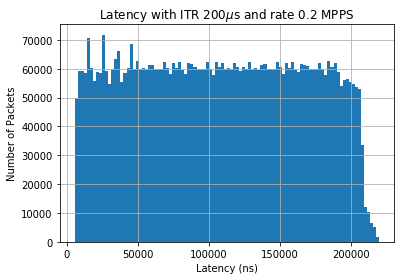

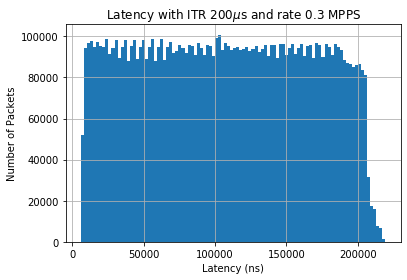

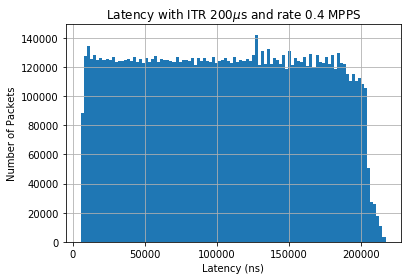

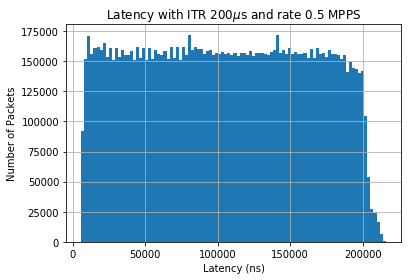

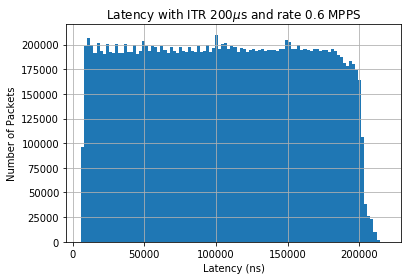

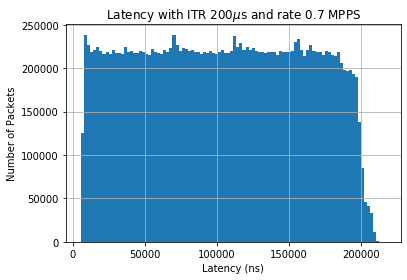

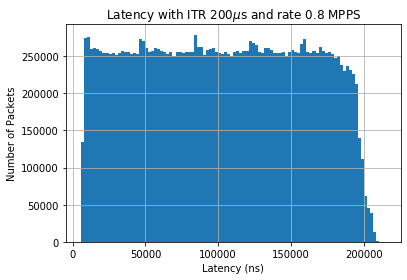

In [50]:
# Plot Latency Histogram
def plot_latency_histogram(latency, weights, rate, itr):
    fig, ax = plt.subplots()
    ax.hist(latency, 100, weights=weights)

    ax.set(xlabel='Latency (ns)', ylabel='Number of Packets',
           title='Latency with ITR ' + str(itr) + r'$\mu$s' + ' and rate ' + str(rate) + " MPPS")
    ax.grid()
    plt.show()
    
for itr in results:
    latency = []
    weights = []
    for rate in results[itr]:
        latency = []
        weights = []
        for i in range(len(results[itr][rate]["latency"]["latency"])):
            if results[itr][rate]["latency"]["weight"][i] >= 10:
                latency.append(results[itr][rate]["latency"]["latency"][i])
                weights.append(results[itr][rate]["latency"]["weight"][i])
        plot_latency_histogram(latency, weights, rate, itr)
        

        

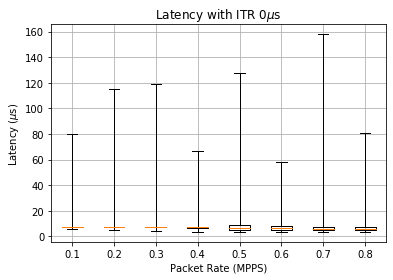

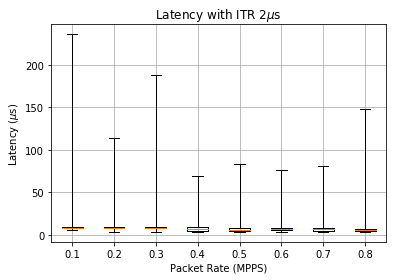

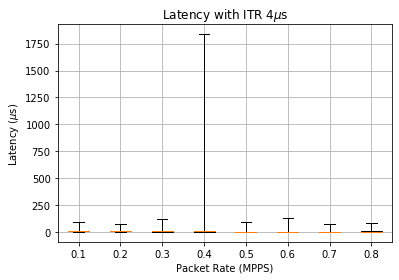

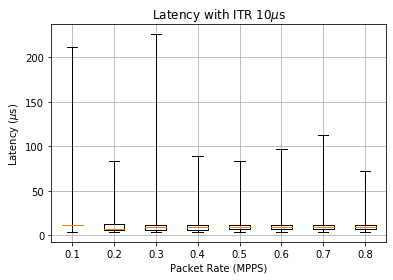

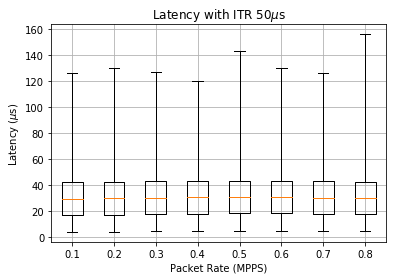

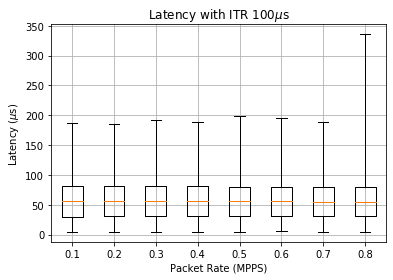

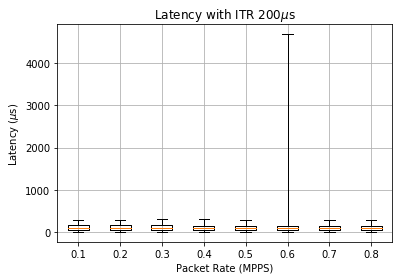

ValueError: x and y must have same first dimension, but have shapes (7,) and (56,)

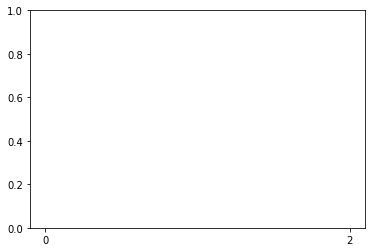

In [51]:
# Plot Boxplots
# pasted from https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy?noredirect=1
def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with np.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

def boxplot_stats(latency, weight, label):
    # returns ['label', 'mean', 'iqr', 'cilo', 'cihi', 'whishi', 'whislo', 'fliers', 'q1', 'med', 'q3']
    quantiles = weighted_quantile(latency, [0, 0.25, 0.5, 0.75, 1], sample_weight=weight, values_sorted=True)
    quantiles = list(map(lambda u: (u / 1000), quantiles))
    low = quantiles[0]
    q25 = quantiles[1]
    q50 = quantiles[2]
    q75 = quantiles[3]
    high = quantiles[4]
    mean = np.average(latency, weights=weight)
    
    return {
        'label': label, 
        'mean': mean, 
        'iqr': abs(q25 - q75), 
        'cilo': 0, 
        'cihi': 0, 
        'whishi': high, 
        'whislo': low, 
        'q1': q25, 
        'med': q50, 
        'q3': q75,
        'fliers': []
    }

def plot_latency_boxplot(latency, weights, rates, itr):
    fig, ax = plt.subplots()
    stats = []
    for i in range(len(latency)):
        stats.append(boxplot_stats(latency[i], weights[i], rates[i]))
    ax.bxp(stats)

    ax.set(xlabel='Packet Rate (MPPS)', ylabel='Latency (' + r'$\mu$s)',
           title='Latency with ITR ' + str(itr) + r'$\mu$s')
    ax.grid()
    plt.show()
    
medians = []
itrs = []
for itr in results:
    latencies = []
    weights = []
    rates = []
    itrs.append(itr)
    for rate in results[itr]:
        latencies.append(results[itr][rate]["latency"]["latency"])
        weights.append(results[itr][rate]["latency"]["weight"])
        rates.append(rate)
    plot_latency_boxplot(latencies, weights, rates, itr)
    for i in range(len(latencies)):
        medians.append(boxplot_stats(latencies[i], weights[i], rates[i])['med'])

plot_interrupt_latency(itrs, medians)
        

        

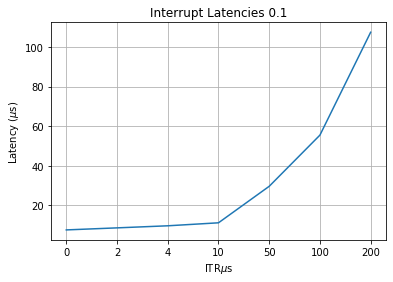

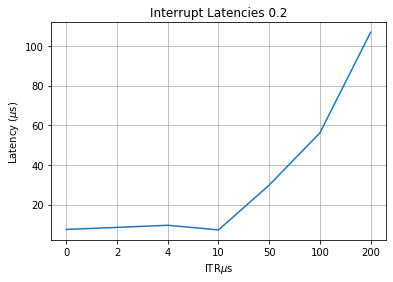

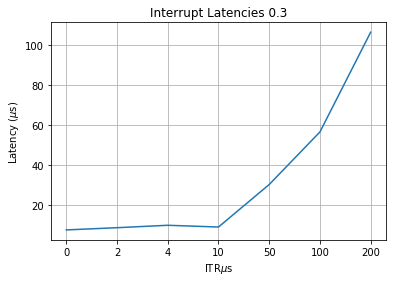

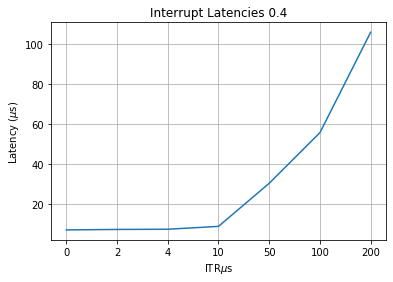

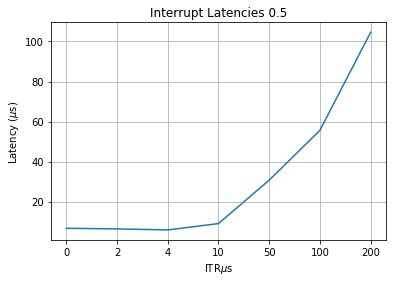

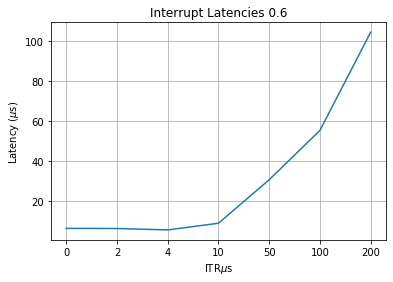

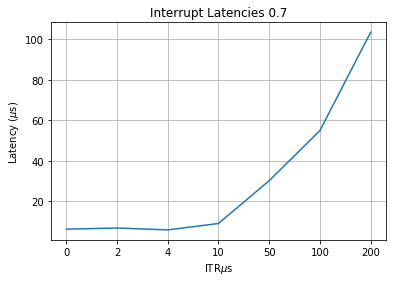

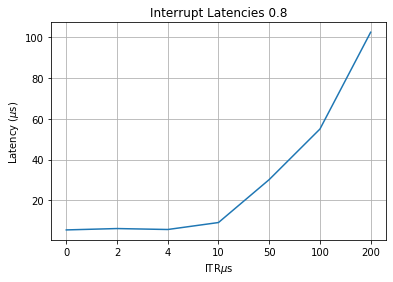

In [54]:
# Plot interrupt latencies
def plot_interrupt_latency(itrs, medians, rate):
    fig, ax = plt.subplots()
    ax.plot(itrs, medians)
    ax.set(xlabel='ITR' + r'$\mu$s', ylabel='Latency (' + r'$\mu$s)',
           title='Interrupt Latencies ' + rate)
    ax.grid()
    plt.show()
    
medians = {}
itrs = []
for itr in results:
    latencies = []
    weights = []
    rates = []
    itrs.append(itr)
    for rate in results[itr]:
        if rate not in medians:
            medians[rate] = []
        medians[rate].append(boxplot_stats(results[itr][rate]["latency"]["latency"], results[itr][rate]["latency"]["weight"], rate)['med'])

for rate in results[itrs[0]]:
    plot_interrupt_latency(itrs, medians[rate], rate)

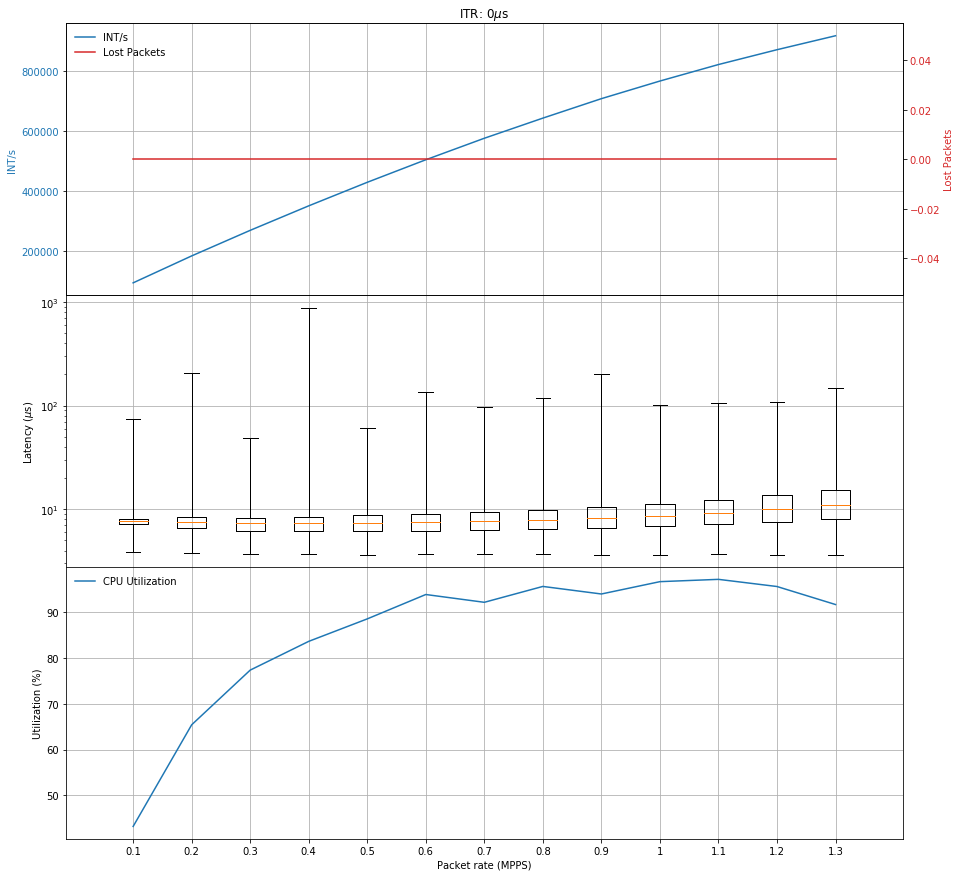

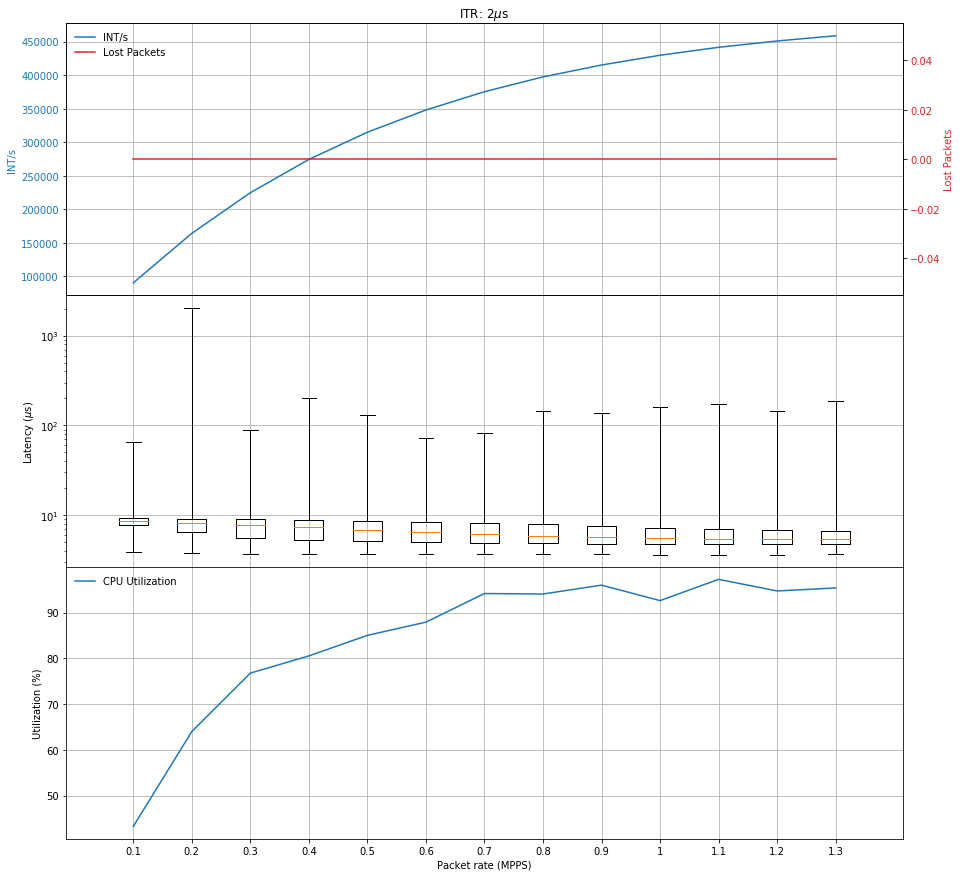

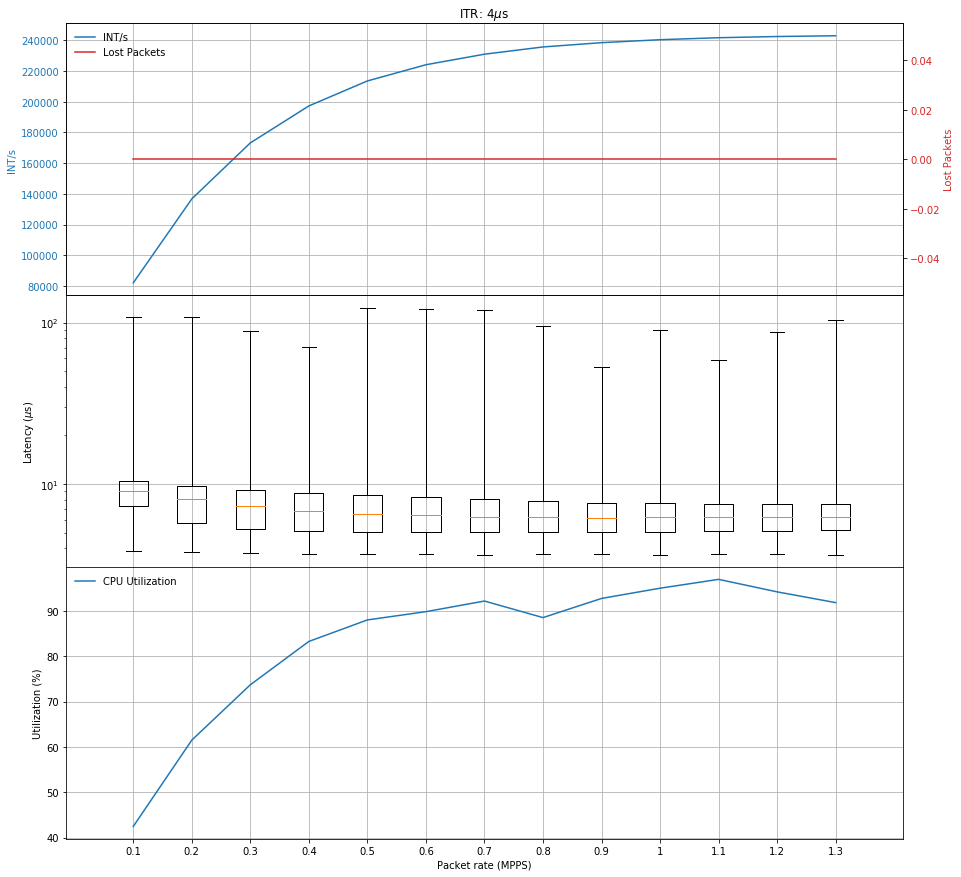

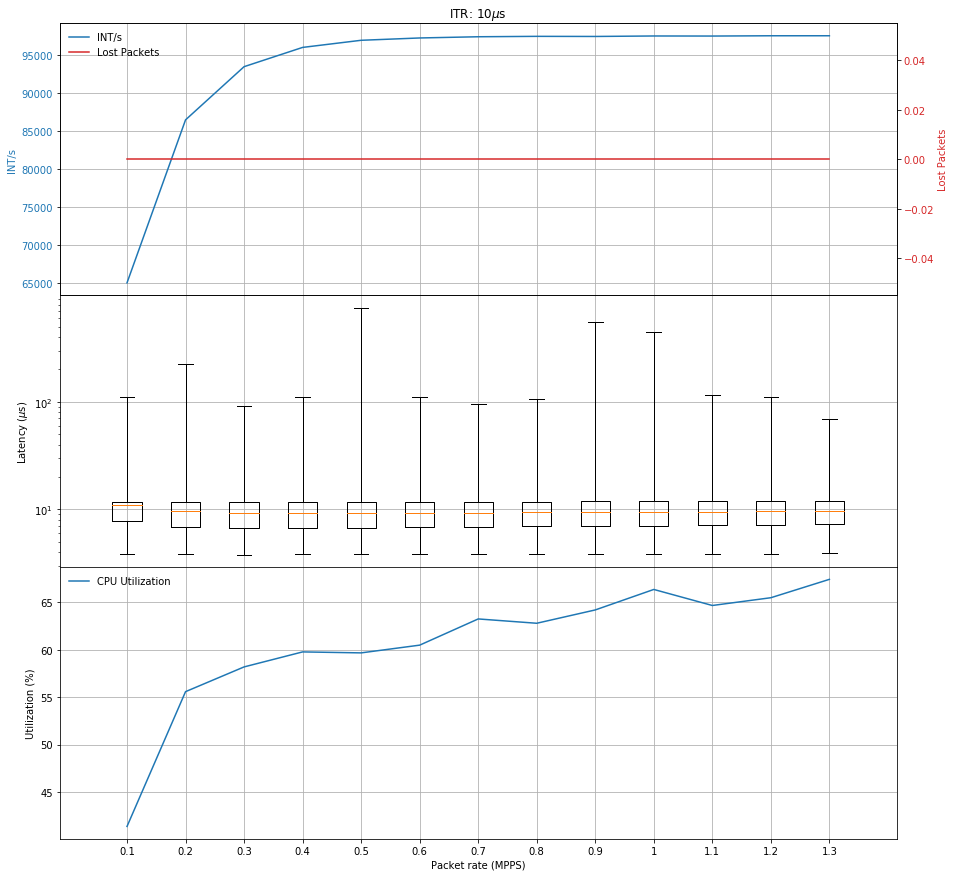

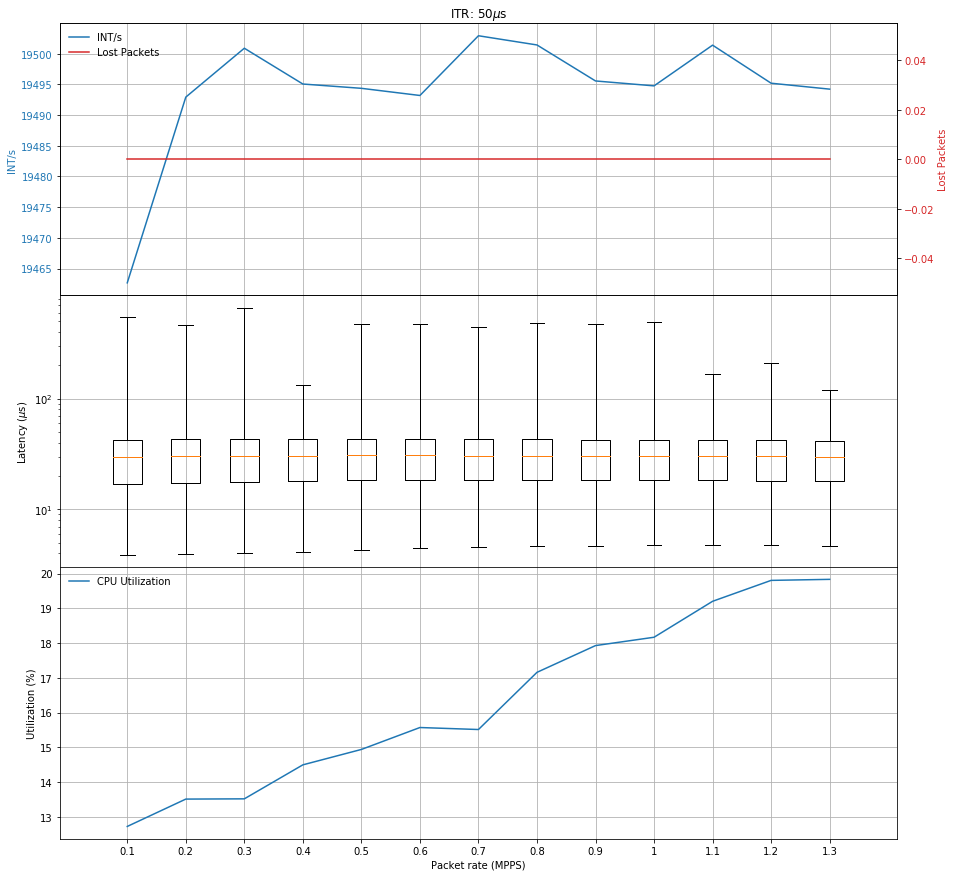

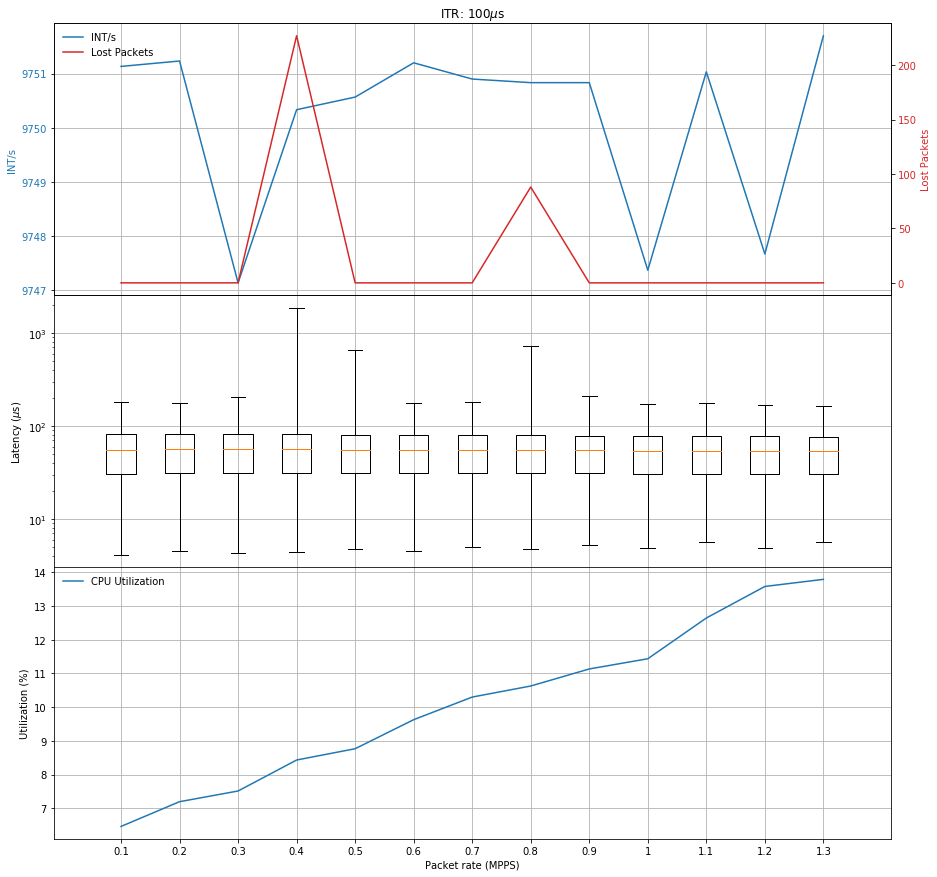

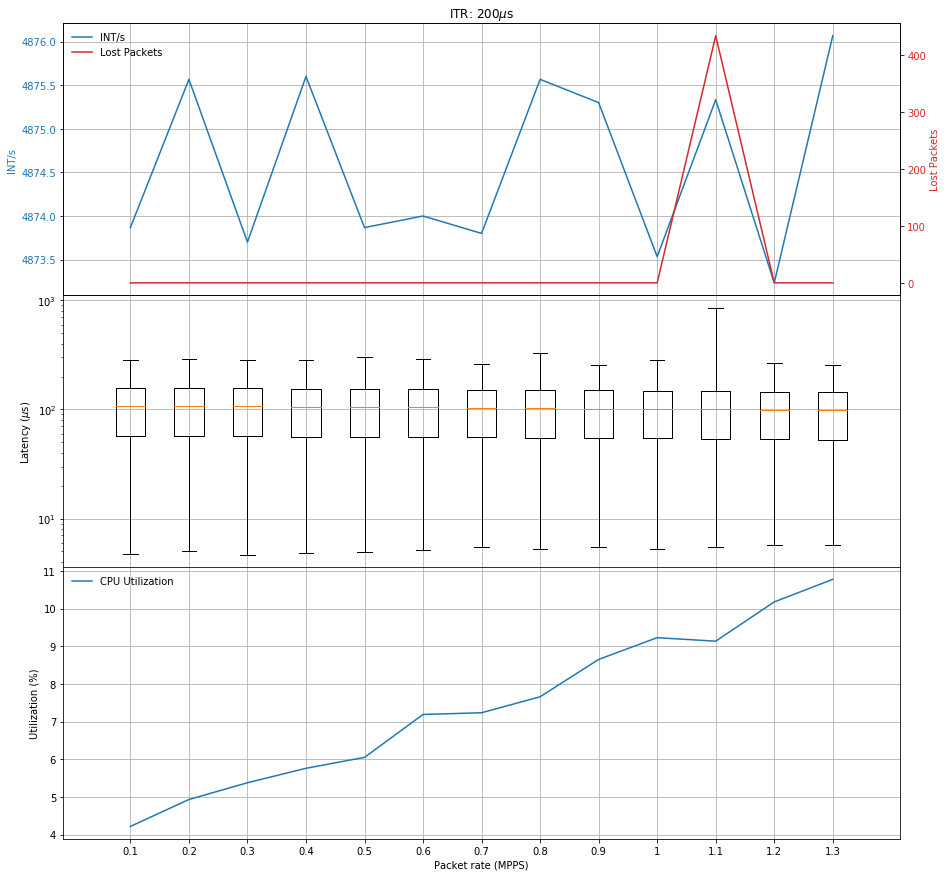

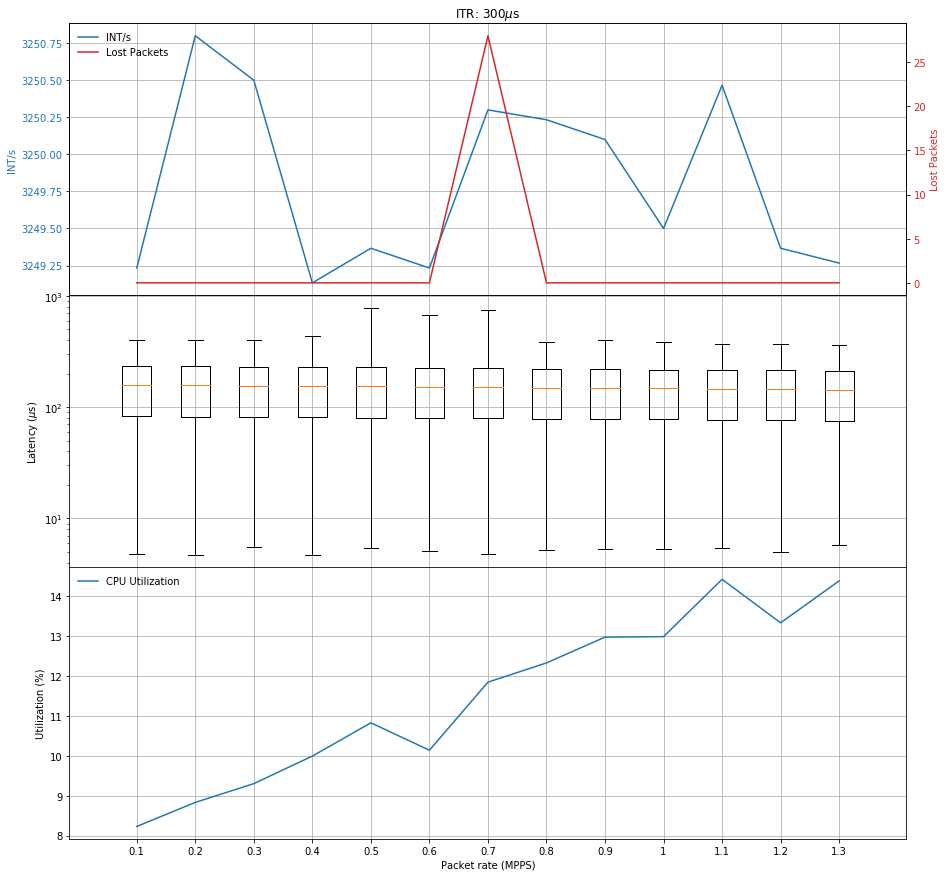

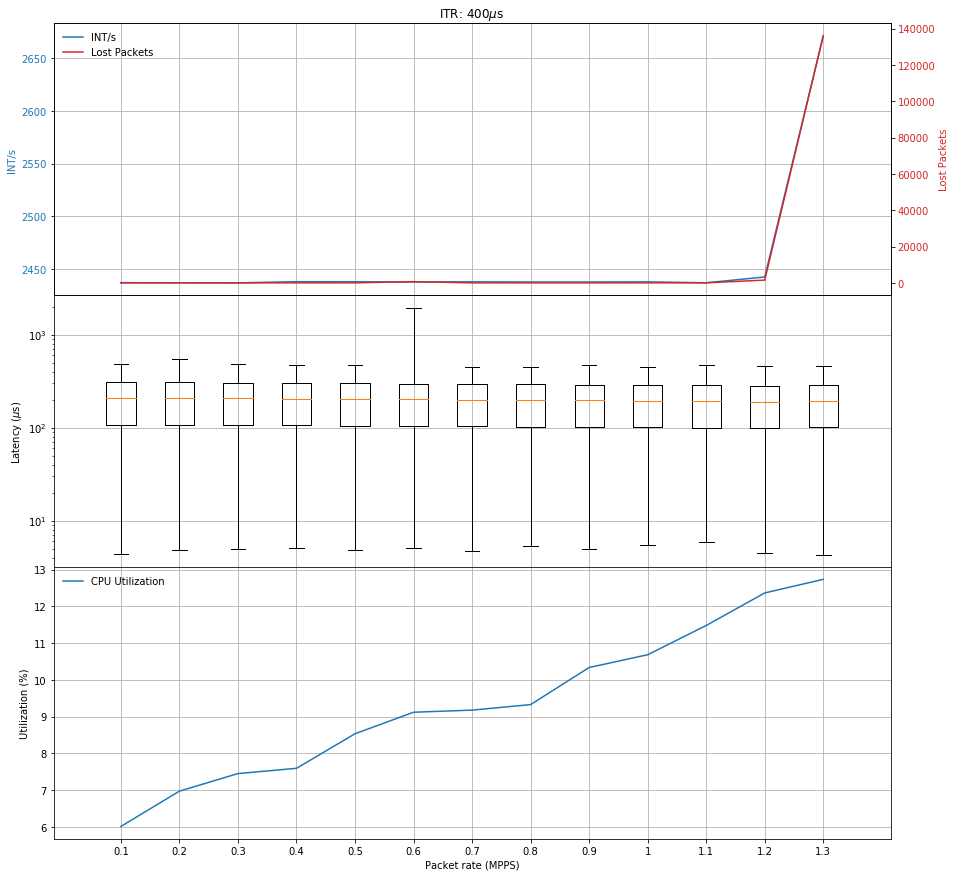

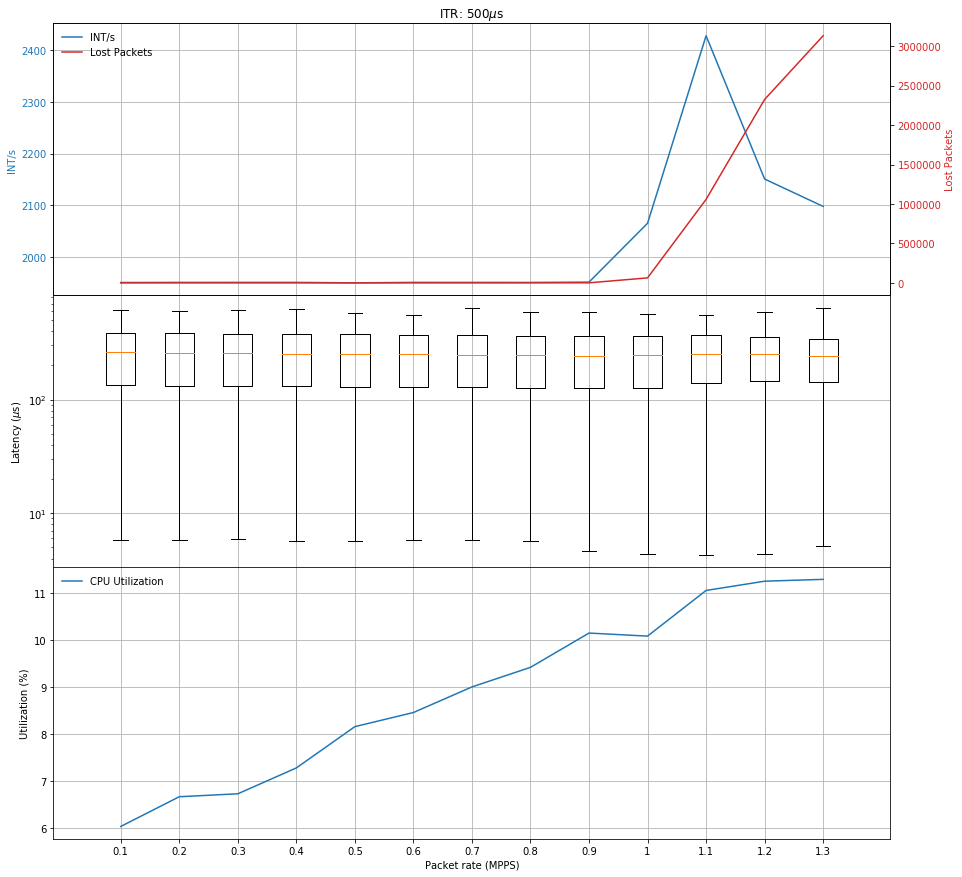

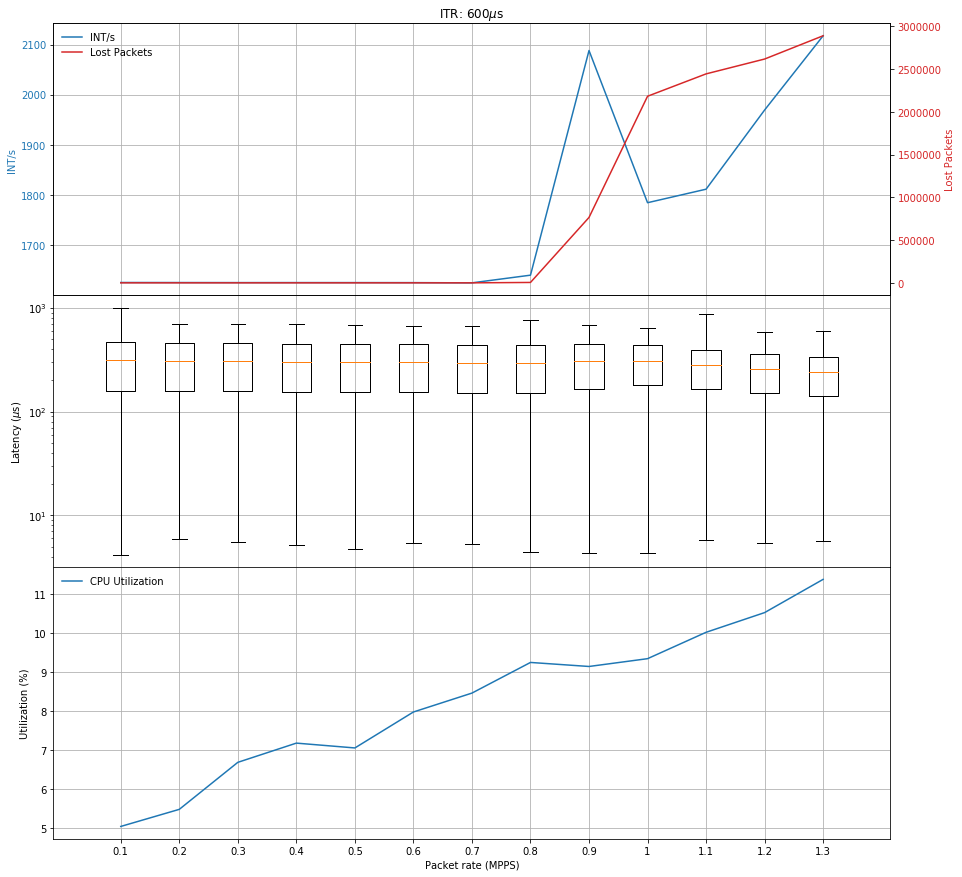

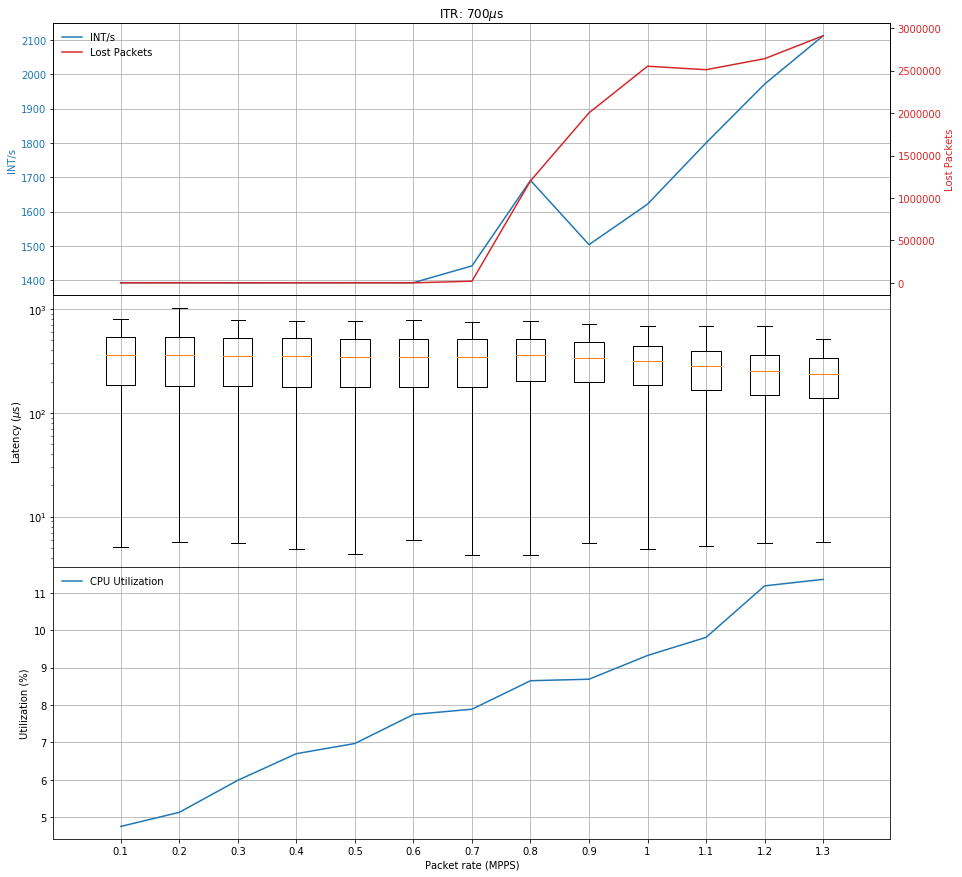

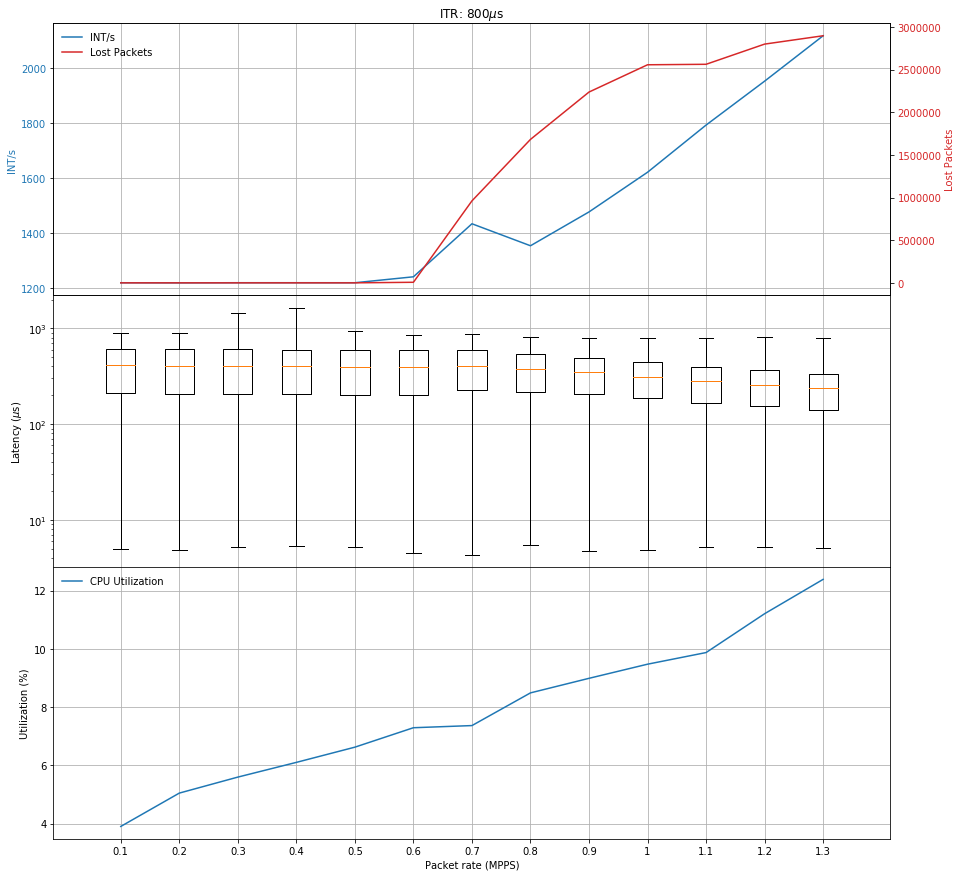

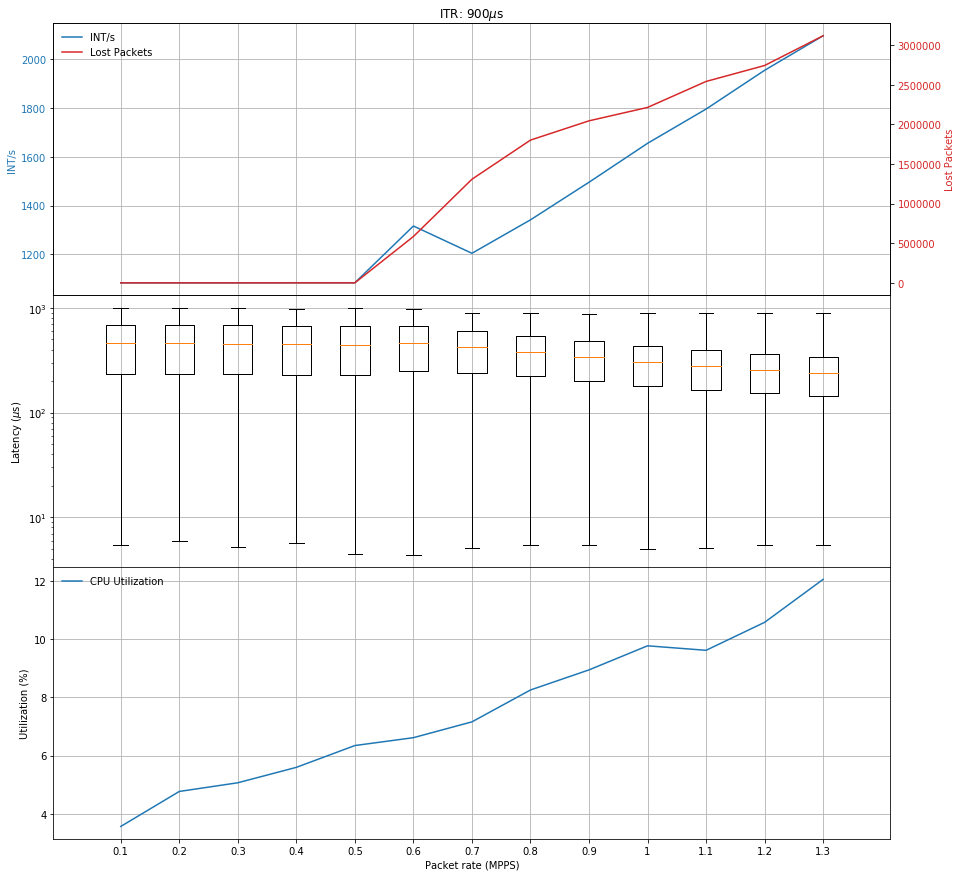

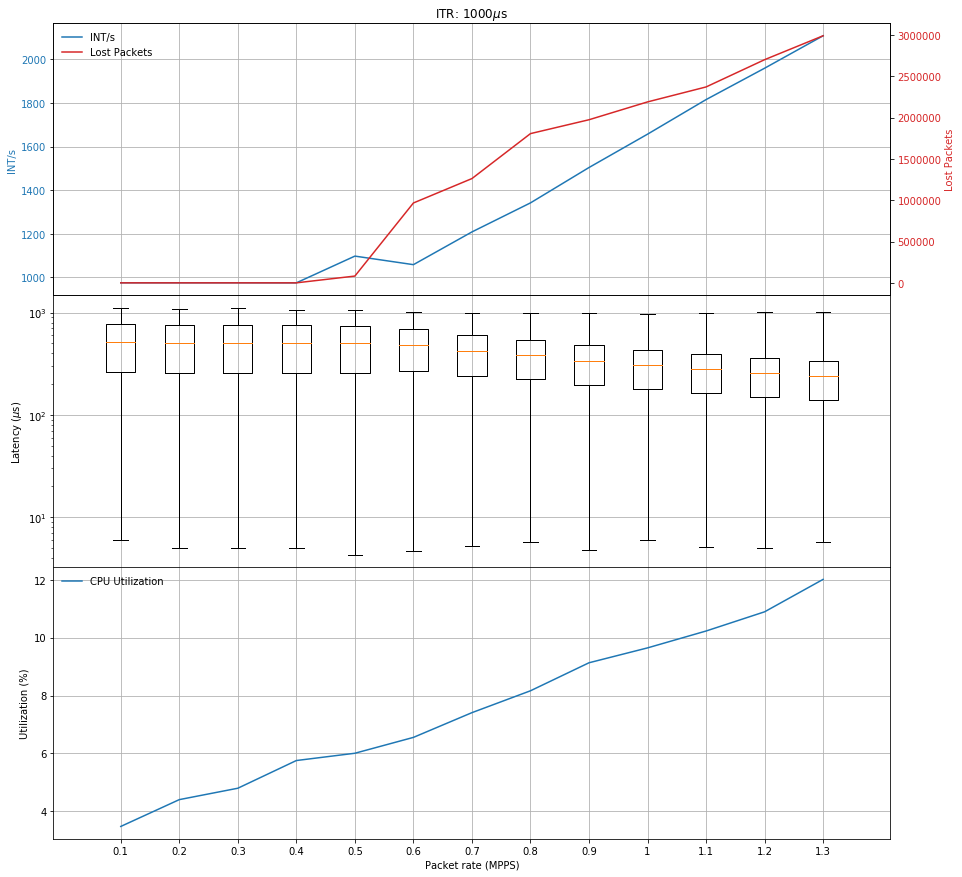

In [11]:
# Combination of CPU Util, INT/s, Latency
def plot_combined(latency, weights, interrupts, lost, cpu_utils, rates, itr):
    fig, [ax1, ax3, ax4] = plt.subplots(3, 1, sharex=True, figsize=(15,15))
    fig.subplots_adjust(hspace=0)
    
    # Plot INT/s and Lost Rate
    ln1 = ax1.plot(rates, interrupts, label='INT/s')
    color = 'tab:blue'
    ax1.yaxis.label.set_color(color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set(ylabel='INT/s', title='ITR: ' + str(itr) + r'$\mu$s')
    ax1.grid()
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ln2 = ax2.plot(rates, lost, color, label='Lost Packets')
    ax2.set(ylabel='Lost Packets')
    ax2.yaxis.label.set_color(color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Plot boxchart
    stats = []
    for i in range(len(latency)):
        stats.append(boxplot_stats(latency[i], weights[i], rates[i])[0])
    ax3.bxp(stats, positions=range(len(latency)))
    ax3.set_yscale('log')

    ax3.set(ylabel='Latency (' + r'$\mu$s)')
    ax3.grid()
    
    # Plot CPU Util
    ax4.plot(rates, cpu_utils, label='CPU Utilization')

    ax4.set(ylabel='Utilization (%)', xlabel='Packet rate (MPPS)')
    ax4.grid()
    ax1.legend(ln1 + ln2, ['INT/s', 'Lost Packets'], loc='upper left', frameon=False)
    ax4.legend(loc='upper left', frameon=False)
    #plt.savefig(itr + ".pdf", bbox_inches='tight')
    #plt.savefig(itr + ".jpg", bbox_inches='tight')
    #export_to_pgf(fig, itr)
    plt.show()
    
for itr in results:
    latencies = []
    weights = []
    rates = []
    lost = []
    interrupts = []
    cpu_utils = []
    for rate in results[itr]:
        latencies.append(results[itr][rate]["latency"]["latency"])
        weights.append(results[itr][rate]["latency"]["weight"])
        rates.append(rate)
        interrupts.append(results[itr][rate]["irq/s"])
        lost.append(results[itr][rate]["lost"])
        cpu_utils.append(results[itr][rate]["cpu_util"])
    plot_combined(latencies, weights, interrupts, lost, cpu_utils, rates, itr)

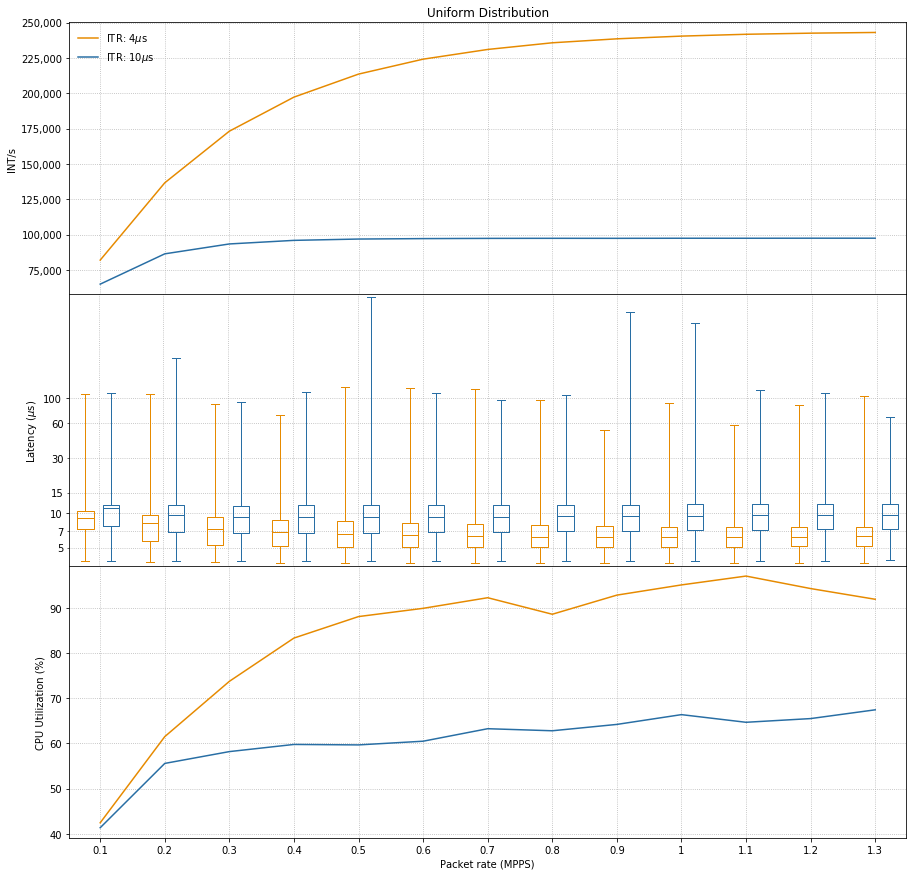

In [12]:
# Combination of CPU Util, INT/s, Latency
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def plot_combined_multi(data1, data2, title):
    color1 = '#e68a00'
    color2 = '#286ea4'
    
    fig, [ax1, ax3, ax4] = plt.subplots(3, 1, figsize=(15,15))
    fig.subplots_adjust(hspace=0)
    
    # Plot INT/s and Lost Rate
    ln1 = ax1.plot(rates, data1['interrupts'], label='INT/s', color=color1)
    ln2 = ax1.plot(rates, data2['interrupts'], label='INT/s', color=color2)
    ax1.set(title=title, ylabel='INT/s')
    ax1.grid(linestyle='dotted')
    ax1.margins(0.04)
    ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Plot boxchart
    stats1 = []
    stats2 = []
    for i in range(len(data1['latencies'])):
        stats1.append(boxplot_stats(data1['latencies'][i], data1['weights'][i], data1['rates'][i])[0])
    for i in range(len(data2['latencies'])):
        stats2.append(boxplot_stats(data2['latencies'][i], data2['weights'][i], data2['rates'][i])[0])
    bpl = ax3.bxp(stats1, positions=np.array(range(len(data1['latencies'])))*2.0-0.4, widths=0.5)
    bpr = ax3.bxp(stats2, positions=np.array(range(len(data2['latencies'])))*2.0+0.4, widths=0.5)
    set_box_color(bpl, color1)
    set_box_color(bpr, color2)
    xticks = [0.02]
    xticks.extend(np.array(range(1, len(data1['latencies']))) * 2)
    ax3.set_xticks(xticks)
    ax3.set_yscale('log')
    ax3.yaxis.set_major_formatter(tick.ScalarFormatter())
    ax3.set_yticks([5, 7, 15, 30, 60], minor=True)
    ax3.tick_params(axis='y', which='minor')
    ax3.yaxis.set_minor_formatter(tick.FormatStrFormatter("%.0f"))
    ax3.margins(0.01)

    ax3.set(ylabel='Latency (' + r'$\mu$s)')
    ax3.grid(linestyle='dotted', which='both')
    
    # Plot CPU Util
    ax4.plot(rates, data1['cpu_utils'], label='CPU Utilization', color=color1)
    ax4.plot(rates, data2['cpu_utils'], label='CPU Utilization', color=color2)

    ax4.set(ylabel='CPU Utilization (%)', xlabel='Packet rate (MPPS)')
    ax4.grid(linestyle='dotted')
    ax1.legend(ln1 + ln2, ['ITR: ' + str(data1['itr']) + r'$\mu$s', 'ITR: ' + str(data2['itr']) + r'$\mu$s'], loc='upper left', frameon=False)
    ax4.margins(0.04)
    #plt.savefig(itr + ".pdf", bbox_inches='tight')
    plt.savefig(itr + ".jpg", bbox_inches='tight')
    #export_to_pgf(fig, itr)
    plt.show()
    
data1 = {}
data2 = {}

itr = '4'
data1['itr'] = itr
data1['latencies'] = []
data1['weights'] = []
data1['rates'] = []
data1['interrupts'] = []
data1['cpu_utils'] = []
for rate in results[itr]:
    data1['latencies'].append(results[itr][rate]["latency"]["latency"])
    data1['weights'].append(results[itr][rate]["latency"]["weight"])
    data1['rates'].append(rate)
    data1['interrupts'].append(results[itr][rate]["irq/s"])
    data1['cpu_utils'].append(results[itr][rate]["cpu_util"])
    
itr = '10'
data2['itr'] = itr
data2['latencies'] = []
data2['weights'] = []
data2['rates'] = []
data2['interrupts'] = []
data2['cpu_utils'] = []
for rate in results[itr]:
    data2['latencies'].append(results[itr][rate]["latency"]["latency"])
    data2['weights'].append(results[itr][rate]["latency"]["weight"])
    data2['rates'].append(rate)
    data2['interrupts'].append(results[itr][rate]["irq/s"])
    data2['cpu_utils'].append(results[itr][rate]["cpu_util"])

plot_combined_multi(data1, data2, 'Uniform Distribution')


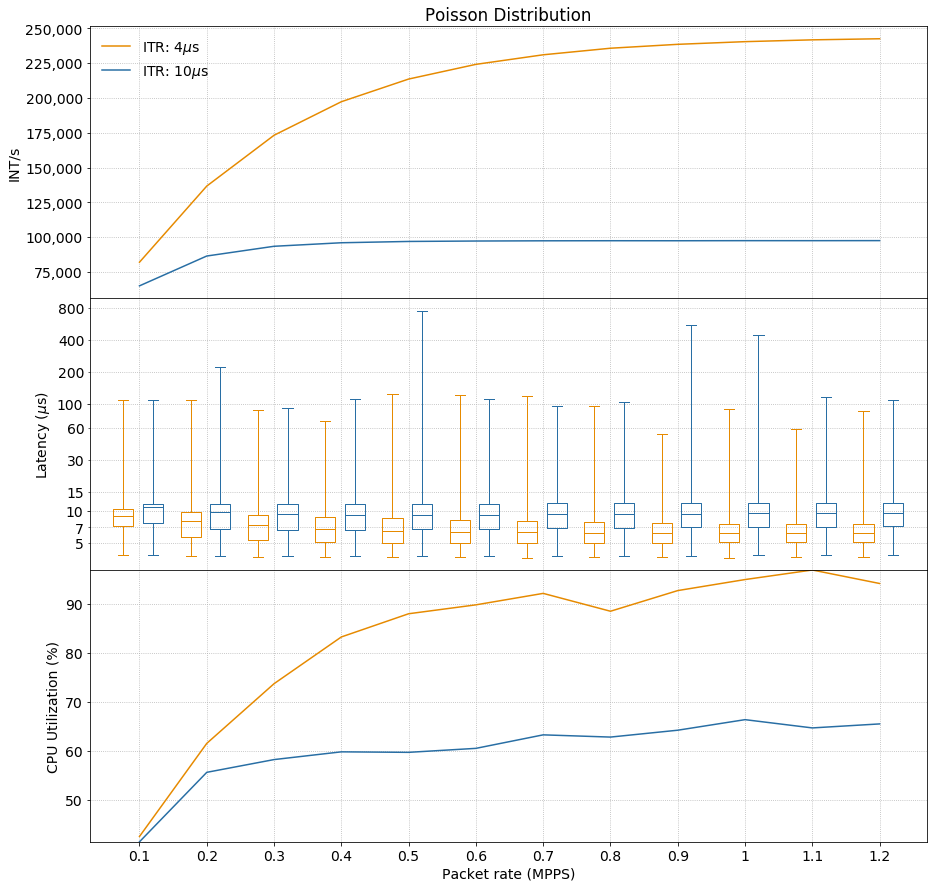

In [18]:
# Combination of CPU Util, INT/s, Latency
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def plot_combined_multi(data1, data2, title):
    color1 = '#e68a00'
    color2 = '#286ea4'
    
    fig, [ax1, ax3, ax4] = plt.subplots(3, 1, sharex=True, figsize=(15,15))
    fig.subplots_adjust(hspace=0)
    
    # Plot INT/s and Lost Rate
    ln1 = ax1.plot(data1['rates'], data1['interrupts'], label='INT/s', color=color1)
    ln2 = ax1.plot(data2['rates'], data2['interrupts'], label='INT/s', color=color2)
    ax1.set(title=title, ylabel='INT/s')
    ax1.grid(linestyle='dotted')
    ax1.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Plot boxchart
    stats1 = []
    stats2 = []
    for i in range(len(data1['latencies'])):
        stats1.append(boxplot_stats(data1['latencies'][i], data1['weights'][i], data1['rates'][i])[0])
    for i in range(len(data2['latencies'])):
        stats2.append(boxplot_stats(data2['latencies'][i], data2['weights'][i], data2['rates'][i])[0])
    bpl = ax3.bxp(stats1, positions=np.array(range(len(data1['latencies'])))-0.24, widths=0.3)
    bpr = ax3.bxp(stats2, positions=np.array(range(len(data2['latencies'])))+0.2, widths=0.3)
    set_box_color(bpl, color1)
    set_box_color(bpr, color2)
    ax3.set_yscale('log')
    ax3.yaxis.set_major_formatter(tick.ScalarFormatter())
    ax3.set_yticks([5, 7, 15, 30, 60, 200, 400,800], minor=True)
    ax3.tick_params(axis='y', which='minor')
    ax3.yaxis.set_minor_formatter(tick.FormatStrFormatter("%.0f"))

    ax3.set(ylabel='Latency (' + r'$\mu$s)')
    ax3.grid(linestyle='dotted', which='both')
    
    # Plot CPU Util
    ax4.plot(data1['rates'], data1['cpu_utils'], label='CPU Utilization', color=color1)
    ax4.plot(data2['rates'], data2['cpu_utils'], label='CPU Utilization', color=color2)

    ax4.set(ylabel='CPU Utilization (%)', xlabel='Packet rate (MPPS)')
    ax4.grid(linestyle='dotted')
    ax1.legend(ln1 + ln2, ['ITR: ' + str(data1['itr']) + r'$\mu$s', 'ITR: ' + str(data2['itr']) + r'$\mu$s'], loc='upper left', frameon=False)
    plt.margins(0)
    font = {'size'   : 14}
    matplotlib.rc('font', **font)
    #plt.savefig(itr + ".pdf", bbox_inches='tight')
    plt.savefig(itr + ".jpg", bbox_inches='tight', quality=100, dpi=600)
    #export_to_pgf(fig, itr)
    plt.show()
    
data1 = {}
data2 = {}

itr = '4'
results[itr].pop('1.3', None)
data1['itr'] = itr
data1['latencies'] = []
data1['weights'] = []
data1['rates'] = []
data1['interrupts'] = []
data1['cpu_utils'] = []
for rate in results[itr]:
    data1['latencies'].append(results[itr][rate]["latency"]["latency"])
    data1['weights'].append(results[itr][rate]["latency"]["weight"])
    data1['rates'].append(rate)
    data1['interrupts'].append(results[itr][rate]["irq/s"])
    data1['cpu_utils'].append(results[itr][rate]["cpu_util"])
    
itr = '10'
results[itr].pop('1.3', None)
data2['itr'] = itr
data2['latencies'] = []
data2['weights'] = []
data2['rates'] = []
data2['interrupts'] = []
data2['cpu_utils'] = []
for rate in results[itr]:
    data2['latencies'].append(results[itr][rate]["latency"]["latency"])
    data2['weights'].append(results[itr][rate]["latency"]["weight"])
    data2['rates'].append(rate)
    data2['interrupts'].append(results[itr][rate]["irq/s"])
    data2['cpu_utils'].append(results[itr][rate]["cpu_util"])

plot_combined_multi(data1, data2, 'Poisson Distribution')
